In [36]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import time
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
use_gpu = torch.cuda.is_available()
print('Is GPU available:', use_gpu)

PyTorch version: 1.0.0
torchvision version: 0.2.1
Is GPU available: True


In [37]:
# 全体的な設定

# デバイス
device = torch.device('cuda' if use_gpu else 'cpu')

# バッチサイズ（もう少し大きくしたいがメモリの都合）
batchsize = 64

# シード値の指定（cuDNNによるランダム性はこれでも残るらしい）
seed = 1
torch.manual_seed(seed)
if use_gpu:
    torch.cuda.manual_seed(seed)

In [38]:
root_dir = '../../data/'
# 訓練画像が入っているディレクトリ（kmnistの漢字データからkanjivgのkanji2radicalにkeyとしてないものを除いた）
image_dir = root_dir + 'kkanji2_expansion_can_get_radical/'
# ログと重みを保存するためのディレクトリ
save_dir = root_dir + 'kkanji2_result/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [39]:
kanji_set = set()
for image_name in os.listdir(image_dir):
    kanji_set.add(image_name[:4])
    
kanji_list = sorted(list(kanji_set))

kanji2index = {}
for index, kanji in enumerate(kanji_list):
    kanji2index[kanji] = index

n_kanji = len(kanji_list)
print('The number of kanjis:', n_kanji)

The number of kanjis: 3566


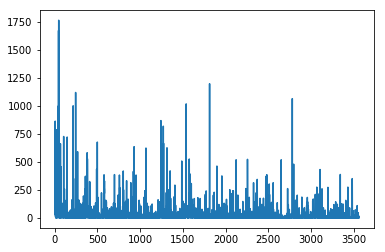

In [40]:
kanji_dist = np.zeros(n_kanji)
for image_name in os.listdir(image_dir):
    kanji_dist[kanji2index[image_name[:4]]] += 1

plt.plot(kanji_dist)
plt.show()

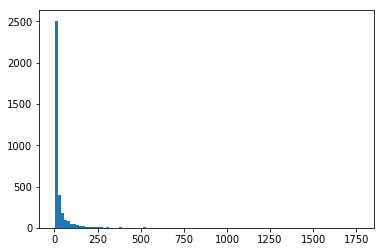

In [43]:
plt.hist(kanji_dist, bins=100)
plt.show()

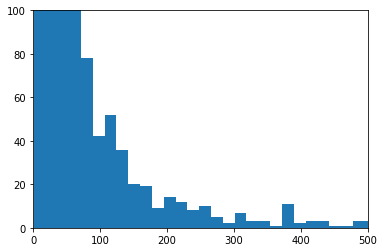

In [44]:
plt.xlim([0,500])
plt.ylim([0,100])
plt.hist(kanji_dist, bins = 100)
plt.show()

In [45]:
class KanjiDataset(Dataset):
    def __init__(self, image_dir, image_name_list, kanji2index, transform=None):
        self.image_dir = image_dir
        self.image_name_list = sorted(image_name_list)
        
        self.kanji2index = kanji2index
        
        self.transform = transform
        
    def __len__(self):
        return len(self.image_name_list)
    
    def __getitem__(self, idx):
        image_name = self.image_name_list[idx]
        image = Image.open(self.image_dir + image_name)
        
        if self.transform:
            image = self.transform(image)
            
        label = self.kanji2index[image_name[:4]]
        
        return image, label

In [46]:
# train_test_splitで分割（高速化のためフォルダ内のファイルの名前を分割している）
train_name_list, validation_name_list = train_test_split(os.listdir(image_dir), test_size = 0.2, random_state = seed)

# data augmentationとして周囲8マスをゼロパディングしてそこから64x64をランダムクロップしている（data augmentationは今ここだけ）
# ToTensor()で0~1の範囲に収めて、そこからNormalize()で-1~1の範囲にしているが、このNormalize()に渡す値は0.5ではよくない気がする
tf_train = transforms.Compose([transforms.RandomCrop(64, padding=8), \
                               transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# validationではランダムクロップはしない
tf_validation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_data = KanjiDataset(image_dir, train_name_list, \
                                 kanji2index, transform=tf_train)
validation_data = KanjiDataset(image_dir, validation_name_list, \
                                      kanji2index, transform=tf_validation)

print('The number of training data:', len(train_data))
print('The number of validation data:', len(validation_data))

# make DataLoader
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_data, batch_size=batchsize, shuffle=False, num_workers=4)

The number of training data: 94127
The number of validation data: 23532


In [59]:
# 普通のシンプルなCNN
class Simple_CNN(nn.Module):
    def __init__(self, n_out):
        super(Simple_CNN, self).__init__()
        base_n_layers = 64
        self.layers1 = nn.Sequential(
                            nn.Conv2d(1, base_n_layers, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(base_n_layers),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layers2 = nn.Sequential(
                            nn.Conv2d(base_n_layers, base_n_layers*2, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(base_n_layers*2),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layers3 = nn.Sequential(
                            nn.Conv2d(base_n_layers*2, base_n_layers*4, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(base_n_layers*4),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layers4 = nn.Sequential(
                            nn.Conv2d(base_n_layers*4, base_n_layers*8, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(base_n_layers*8),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(base_n_layers*8*4*4, n_out)
        
    def forward(self, x):
        out = self.layers1(x)
        out = self.layers2(out)
        out = self.layers3(out)
        out = self.layers4(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [60]:
net = Simple_CNN(n_kanji)
net = net.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=5e-4)

num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print('The number of trainable parameters:', num_trainable_params)
print('\nModel:\n', net)
print('\nLoss function:\n', criterion)
print('\nOptimizer:\n', optimizer)

The number of trainable parameters: 30767982

Model:
 Simple_CNN(
  (layers1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers4): Sequential(
    (0): Conv2d(256, 512, 

In [61]:
# 1epoch分の訓練
def train(train_loader):
    net.train()
    running_loss = 0
    correct = 0
    
    for batch_index, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds = outputs.detach().max(1, keepdim=True)[1]
        correct += preds.eq(labels.view_as(preds)).sum().item()
        
        print('\rtraining batch[%4d/%4d]' % (batch_index+1, len(train_loader)), end='')
        
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / len(train_loader.dataset)
    
    return train_loss, train_accuracy

In [62]:
# 1epoch分のvalidation
def validation(validation_loader):
    net.eval()
    running_loss = 0
    correct = 0
    
    with torch.no_grad():
        for batch_index, (inputs, labels) in enumerate(validation_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            preds = outputs.max(1, keepdim=True)[1]
            correct += preds.eq(labels.view_as(preds)).sum().item()
            
            print('\rvalidation batch[%4d/%4d]' % (batch_index+1, len(validation_loader)), end='')
            
    validation_loss = running_loss / len(validation_loader)
    validation_accuracy = correct / len(validation_loader.dataset)
    
    return validation_loss, validation_accuracy

In [63]:
train_loss_list = []
train_accuracy_list = []

validation_loss_list = []
validation_accuracy_list = []

n_epochs = 50

for epoch in range(n_epochs):
    train_loss, train_accuracy = train(train_loader)
    validation_loss, validation_accuracy = validation(validation_loader)
    
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)
    
    print('')
    print('epoch[%3d/%3d] train[loss:%1.5f accuracy:%1.5f]' \
          % (epoch+1, n_epochs, train_loss, train_accuracy), \
          '\n          validation[loss:%1.5f accuracy:%1.5f]'
          % (validation_loss, validation_accuracy))
    
    if epoch % 5 == 0 and epoch > 0:
        torch.save(net.state_dict(), save_dir + 'kanji_baseline_simpleCNN_weights_epoch_%d.pth' % (epoch+1))
        torch.save(optimizer.state_dict(), save_dir + 'kanji_baseline_simpleCNN_optimizer_epoch_%d.pth' % (epoch+1))
        optimizer.param_groups[0]['lr'] *= 0.1
    
np.save(save_dir + 'kanji_baseline_simpleCNN_train_loss_list.npy', np.array(train_loss_list))
np.save(save_dir + 'kanji_baseline_simpleCNN_train_accuracy.npy', np.array(train_accuracy_list))

np.save(save_dir + 'kanji_baseline_simpleCNN_validation_loss_list.npy', np.array(validation_loss_list))
np.save(save_dir + 'kanji_baseline_simpleCNN_validation_accuracy.npy', np.array(validation_accuracy_list))

torch.save(net.state_dict(), save_dir + 'kanji_baseline_simpleCNN_weights_final.pth')

validation batch[ 368/ 368]
epoch[  1/ 50] train[loss:3.45949 accuracy:0.44929] 
          validation[loss:1.46635 accuracy:0.73466]
validation batch[ 368/ 368]
epoch[  2/ 50] train[loss:1.39887 accuracy:0.72989] 
          validation[loss:1.04375 accuracy:0.80371]
validation batch[ 368/ 368]
epoch[  3/ 50] train[loss:1.01771 accuracy:0.79001] 
          validation[loss:0.91806 accuracy:0.82509]
validation batch[ 368/ 368]
epoch[  4/ 50] train[loss:0.83695 accuracy:0.82092] 
          validation[loss:0.83314 accuracy:0.84162]
validation batch[ 368/ 368]
epoch[  5/ 50] train[loss:0.73483 accuracy:0.83756] 
          validation[loss:0.80343 accuracy:0.84442]
validation batch[ 368/ 368]
epoch[  6/ 50] train[loss:0.65669 accuracy:0.84927] 
          validation[loss:0.77443 accuracy:0.84884]
validation batch[ 368/ 368]
epoch[  7/ 50] train[loss:0.29691 accuracy:0.93212] 
          validation[loss:0.57102 accuracy:0.89533]
validation batch[ 368/ 368]
epoch[  8/ 50] train[loss:0.22154 accurac

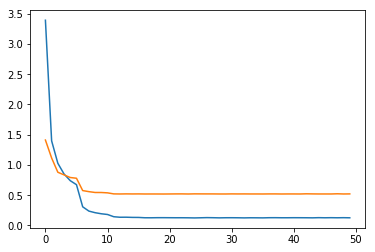

In [33]:
plt.plot(train_loss_list)
plt.plot(validation_loss_list)

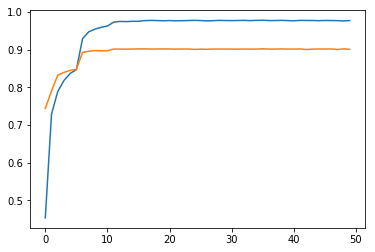

In [35]:
plt.plot(train_accuracy_list)
plt.plot(validation_accuracy_list)

亻
尹


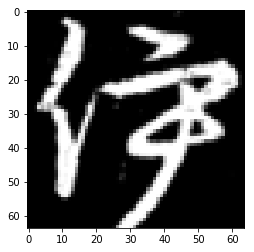

In [68]:
test_loader = DataLoader(validation_data, batch_size=batchsize, shuffle=True, num_workers=4)
images, labels =  iter(test_loader).next()

plt.imshow(images[0].view(64,64).numpy() * 0.5 + 0.5, cmap='gray')
for index, label in enumerate(labels[0]):
    if label == 1:
        print(radical_list[index])

In [72]:
outputs = net(images).cpu()
for index, output in enumerate(outputs[0]):
    if output == 1:
        print(radical_list[index])

ERROR! Session/line number was not unique in database. History logging moved to new session 236


RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at /pytorch/aten/src/TH/THGeneral.cpp:201